In [143]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import os
import time
import matplotlib.cm as cm
import math
import numpy as np
from pathlib import Path

from typing import *
from functional import seq

In [3]:
pd.options.display.float_format = '{:.4f}'.format
plt.rcParams.update({
    "text.usetex": True,
})

In [47]:
dataset_list = widgets.Dropdown(
    options=[
        "simple", "cluto", "complex"
    ],
    index=0,
    description="Dataset:"
)

epsilon_slider = widgets.FloatSlider(
    min=1e-3,
    max=1.0,
    value=0.99,
    step=1e-3,
    description=r"$$\varepsilon$$",
)

min_pts_slider = widgets.IntSlider(
    min=1,
    max=100,
    value=10,
    description=r"$$\texttt{min_pts}$$"
)

prefilter_dropdown = widgets.Dropdown(
    options=[
        "none", "realveclen", "zpnveclen"
    ],
    index=0,
    description="Prefiltering:"
)

In [6]:
def get_dataset_path_from_name(name: str) -> str:
    if name == "cluto":
        return "data/cluto-t7-10k/data.arff"
    elif name == "complex":
        return "data/complex9/data.arff"
    return "data/example/data.arff"

In [56]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [85]:
BORDER_POINT = "Border"
NOISE_POINT = "Noise"
MULTIPLE_CLUSTERS = "Multiple Clusters"


def read_data(path: str) -> Tuple[np.ndarray, np.ndarray]:
    with open(path) as f:
        lines = [line for line in f.read().split("\n") if len(line) > 0]
    coords = []
    labels = []
    for line in lines:
        components = line.split(",")
        x, y = float(components[1]), float(components[2])
        point_type = int(components[4])
        assignments = components[5:]
        if point_type == -1:
            labels.append(NOISE_POINT)
        elif point_type == 0 and len(assignments) > 1:
            labels.append(MULTIPLE_CLUSTERS)
        elif point_type == 0 and len(assignments) == 1:
            labels.append(BORDER_POINT)
        else:
            labels.append(str(assignments[-1]))

        coords.append((x, y))

    return np.array(coords), np.array(labels)


def read_raw_data(path: str) -> np.array:
    with open(path) as f:
        lines = [line for line in f.read().split("\n") if len(line) > 0]
    coords = []
    for line in lines:
        if line.startswith("%") or line.startswith("@"):
            continue
        components = line.split(",")
        x, y = float(components[0]), float(components[1])
        coords.append((x, y))
    return np.array(coords)


def visualize(path: str, legend=True):
    x, y = read_data(path)
    colormap = cm.get_cmap("tab10")
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    print("Num multiple border points: {}".format(get_num_border_points_with_multiple_assignments(Path(path))))
    
    for label in natural_sort(np.unique(y)):
        ix = np.where(y == str(label))[0]
        ax.scatter(x[ix, 0], x[ix, 1], s=15, label=label, cmap=colormap)
    if legend:
        ax.legend()
    return fig

def visualize_raw(path: str, legend=True):
    x = read_raw_data(path)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.scatter(x[:, 0], x[:, 1], s=15)
    ax.set_xlabel(r"$$x_1$$")
    ax.set_ylabel(r"$$x_2$$")
    return fig


In [81]:
def get_class_assignments(file_path: Path) -> List[List[int]]:
    data = file_path.read_text().split("\n")
    dataset = file_path.parent.name.split("_")[0]
    dataset = dataset if "cluto" not in dataset else "cluto"
    output = []
    for line in data:
        if len(line) == 0:
            continue
        components = line.split(",")
        class_assignments = seq(components[5:]).map(int).list()
        output.append(class_assignments)
    return output

def get_num_border_points_with_multiple_assignments(path: Path) -> int:
    return seq(get_class_assignments(path)).filter(lambda x: len(x) > 1).map(len).sum()

# DBSCAN+, RealVecLen-DBSCAN+, ZPNVecLen-DBSCAN+ with respect to the Tanimoto measure

prepared by: Kacper Kania

## Definition of the task

- Implement DBSCAN+ algorithm that allows multiple points to have multiple clusters assigned to them
- The whole algorithm should calculate "distances" according to the Tanimoto measure
- Implement additional heuristics, namely RealVecLen and ZPNVecLen, that limits the total number of points that are evaluated when the algorithm determines a neighbourhood of a single point

## Gathering the data

In [126]:
%%bash 
mkdir -p data/example

python python/produce_example_data.py data/example
python python/make_dataset_zpn.py \
    data/example/data.arff \
    data/example/data_zpn.arff \
    --thresholds -1 1 \
    --labels -2 0 1 \
    --has_labels

Estimated number of clusters: 3
Estimated number of noise points: 22
Estimated number of clusters: 2
Estimated number of clusters: 2
Estimated number of noise points: 0
Estimated number of noise points: 0


In [127]:
%%bash
echo "Downloading complex9 dataset ..."
mkdir data/complex9
wget https://raw.githubusercontent.com/deric/clustering-benchmark/master/src/main/resources/datasets/artificial/complex9.arff \
    -O data/complex9/data.arff

mkdir: cannot create directory ‘data/complex9’: File exists
--2021-01-24 23:23:32--  https://raw.githubusercontent.com/deric/clustering-benchmark/master/src/main/resources/datasets/artificial/complex9.arff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.64.133, 151.101.128.133, 151.101.192.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53485 (52K) [text/plain]
Saving to: ‘data/complex9/data.arff’

     0K .......... .......... .......... .......... .......... 95% 1.89M 0s
    50K ..                                                    100% 23.3M=0.03s

2021-01-24 23:23:32 (1.96 MB/s) - ‘data/complex9/data.arff’ saved [53485/53485]



In [128]:
%%bash
./download_data.sh

Making ZPN datasets ...


Estimated number of clusters: 3
Estimated number of noise points: 22
Estimated number of clusters: 2
Estimated number of clusters: 2
Estimated number of noise points: 0
Estimated number of noise points: 0
mkdir: cannot create directory ‘data/complex9’: File exists
--2021-01-24 23:23:46--  https://raw.githubusercontent.com/deric/clustering-benchmark/master/src/main/resources/datasets/artificial/complex9.arff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.64.133, 151.101.128.133, 151.101.192.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53485 (52K) [text/plain]
Saving to: ‘data/complex9/data.arff’

     0K .......... .......... .......... .......... .......... 95% 2.00M 0s
    50K ..                                                    100% 95.6M=0.02s

2021-01-24 23:23:46 (2.09 MB/s) - ‘data/complex9/data.arff’ saved [53485/53485]

mkdir: cann

## Building

In [131]:
%%bash
rm -rf build/*
cd build
cmake ..
make -j8
cd ..

-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Boost: /usr/lib/x86_64-linux-gnu/cmake/Boost-1.71.0/BoostConfig.cmake (found version "1.71.0") found components: iostreams 
-- Configuring done
-- Generating done
-- Build files have been written to: /home/kacper/Projects/dbscan-zpn-realvec-len/build
Scanning dependencies of target dbscan_zpn_realvec_len
[ 12%] Building CXX object CMakeFiles/dbscan_zpn_realvec_len.dir/src/dbscan.cpp.o
[ 25%] Bu

## Using the program

In [132]:
%%bash
./dbscan_zpn_realvec_len --help

DBSCAN+ Testing utility
Usage: ./dbscan_zpn_realvec_len [OPTIONS] [file] [experiment_name]

Positionals:
  file TEXT                   Path to the dataset
  experiment_name TEXT        Name of the experiment

Options:
  -h,--help                   Print this help message and exit
  --eps FLOAT                 Epsilon parameter
  --min_pts INT               Minimum number of points
  --algorithm_name TEXT       Name of the algorithm to use. One of: ["base", "tanimoto"]
  --prefiltering_name TEXT    Name of the prefiltering type to use. One of: ["none", "realveclen", "zpnveclen"]
  --has_labels                Whether dataset has labels
  --standardize               Whether the dataset should be standardized
  --visualize                 Whether the results should be visualized (doesn't work when running in a container)
  --verbose                   Whether to print all messages



In [118]:
@widgets.interact(
    dataset=dataset_list,
    epsilon=epsilon_slider,
    min_pts=min_pts_slider,
    prefilter=prefilter_dropdown,
)
def run_command(dataset, epsilon, min_pts, prefilter):
    os.environ["EPS"] = str(epsilon)
    os.environ["MIN_PTS"] = str(min_pts)
    os.environ["DATASET"] = get_dataset_path_from_name(dataset)
    os.environ["PREFILTER"] = prefilter

interactive(children=(Dropdown(description='Dataset:', options=('simple', 'cluto', 'complex'), value='simple')…

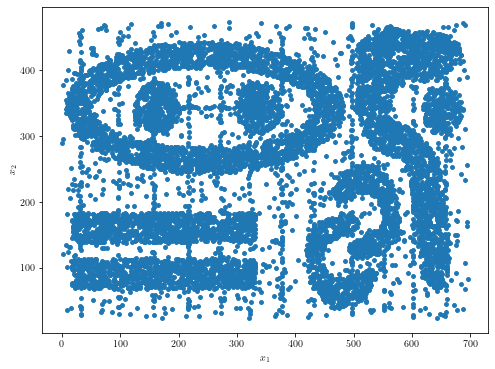

In [148]:
visualize_raw(os.environ["DATASET"])
plt.show()

In [120]:
%%bash
./dbscan_zpn_realvec_len \
    ${DATASET} \
    slideshow \
    --has_labels \
    --eps ${EPS} \
    --min_pts ${MIN_PTS} \
    --algorithm_name tanimoto \
    --prefiltering_name ${PREFILTER}

In [121]:
cat experiments/slideshow/STAT

input_file: data/cluto-t7-10k/data.arff
Eps: 0.813
minPts: 27
runtimes_miliseconds:
	-data_reading: 8
	-model_fitting: 5979
total_runtime_miliseconds: 5987
num_discovered_clusters: 2
nun_discovered_core_points: 9992
nun_discovered_border_points: 1
num_discovered_noise_points: 7
avg_num_calculations_of_similarity: 5729.59
avg_num_cluster_assignments: 1
num_true_positives: 8165726
num_true_negatives: 18416
purity: 0.276
rand: 0.163699
silhouette: 0
davis_bouldin: 0


Num multiple border points: 0


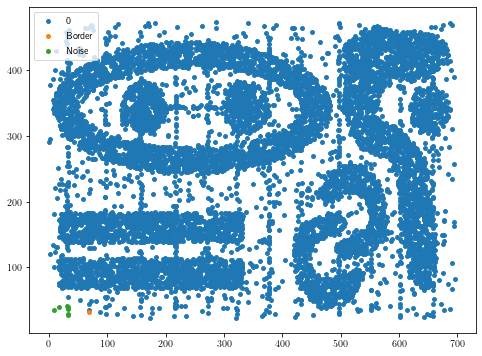

In [147]:
visualize("experiments/slideshow/OUT")
plt.show()

In [159]:
%%timeit
%%bash
./dbscan_zpn_realvec_len \
    data/example/data.arff \
    without_realveclen \
    --has_labels \
    --eps 0.99 \
    --min_pts 10 \
    --algorithm_name tanimoto \
    --prefiltering_name none

83.4 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [160]:
%%timeit
%%bash
./dbscan_zpn_realvec_len \
    data/example/data.arff \
    without_realveclen \
    --has_labels \
    --eps 0.99 \
    --min_pts 10 \
    --algorithm_name tanimoto \
    --prefiltering_name realveclen

64.4 ms ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
# !docker build -t dami . 

Sending build context to Docker daemon   9.48MB
Step 1/10 : FROM ubuntu:20.04
 ---> f643c72bc252
Step 2/10 : VOLUME /usr/src/dami/experiments
 ---> Using cache
 ---> 3e64825a4e52
Step 3/10 : ENV DEBIAN_FRONTEND noninteractive
 ---> Using cache
 ---> 20acf00f32a6
Step 4/10 : RUN apt-get update     && apt-get upgrade -y     && apt-get install -y          libboost-dev         libboost-iostreams-dev         g++         gcc         make         cmake         python3         python3-dev         python3-pip         wget         curl         texlive-fonts-recommended         dvipng         cm-super         texlive-latex-extra     && rm -rf /var/lib/apt/lists/*     && ln -sf python3 /usr/bin/python
 ---> Using cache
 ---> 629d9a834e8d
Step 5/10 : WORKDIR /usr/src/dami
 ---> Using cache
 ---> 57aa78eeccc3
Step 6/10 : COPY . .
 ---> Using cache
 ---> 1d2ecf0314e6
Step 7/10 : RUN mkdir build     && cd build     && cmake ..     && make -j8
 ---> Using cache
 ---> ff071e50be07
Step 8/10 : RUN pip3 i

  Created wheel for black: filename=black-20.8b1-py3-none-any.whl size=124184 sha256=694d8f005c0770219e1f8c3307016799353c1785c9329ec03f32306e6e06b436
  Stored in directory: /root/.cache/pip/wheels/95/a4/59/10cd5378d52f92cdb45025f040e4686e10ae5217961c25fd66
  Created wheel for pandocfilters: filename=pandocfilters-1.4.3-py3-none-any.whl size=7991 sha256=df67aef84498de42d7f5a3eef66dd549860e1f4517f65871ce04de4bef8594cd
  Stored in directory: /root/.cache/pip/wheels/fc/39/52/8d6f3cec1cca4ceb44d658427c35711b19d89dbc4914af657f
  Created wheel for pyrsistent: filename=pyrsistent-0.17.3-cp38-cp38-linux_x86_64.whl size=106644 sha256=e3ce61c6b7bd634994061e15e1ce554cabdfa030780517b85aebd55514b2e94c
  Stored in directory: /root/.cache/pip/wheels/3d/22/08/7042eb6309c650c7b53615d5df5cc61f1ea9680e7edd3a08d2
Successfully built black pandocfilters pyrsistent
Removing intermediate container 7dcb264cf418
 ---> 3c96591a7b60
Step 9/10 : RUN ./download_data.sh
 ---> Running in 02b95bc84f78
Estimated number 

Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.64.133, 151.101.128.133, 151.101.192.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 719873 (703K) [text/plain]
Saving to: 'data/letter/data.arff'

     0K .......... .......... .......... .......... ..........  7% 2.02M 0s
    50K .......... .......... .......... .......... .......... 14% 6.19M 0s
   100K .......... .......... .......... .......... .......... 21% 2.91M 0s
   150K .......... .......... .......... .......... .......... 28% 9.32M 0s
   200K .......... .......... .......... .......... .......... 35% 9.66M 0s
   250K .......... .......... .......... .......... .......... 42% 2.86M 0s
   300K .......... .......... .......... .......... .......... 49% 9.00M 0s
   350K .......... .......... .......... .......... .......... 56% 3.27M 0s
   400K .......... .......... .......... ..........

In [123]:
%%bash
docker run -i --rm dami \
    ./dbscan_zpn_realvec_len \
    ${DATASET} \
    from_docker \ 
    --has_labels \
    --eps ${EPS} \
    --min_pts ${MIN_PTS} \
    --algorithm_name tanimoto \
    --prefiltering_name ${PREFILTER}

In [124]:
cat experiments/from_docker/STAT

input_file: data/example/data.arff
Eps: 0.813
minPts: 27
runtimes_miliseconds:
	-data_reading: 0
	-model_fitting: 38
total_runtime_miliseconds: 38
num_discovered_clusters: 2
nun_discovered_core_points: 722
nun_discovered_border_points: 13
num_discovered_noise_points: 15
avg_num_calculations_of_similarity: 750
avg_num_cluster_assignments: 1
num_true_positives: 92150
num_true_negatives: 2500
purity: 0.34
rand: 0.336983
silhouette: 0
davis_bouldin: 0


Num multiple border points: 0


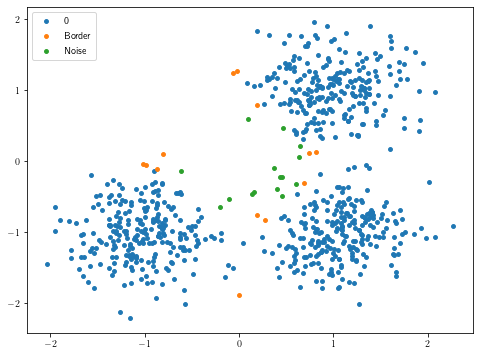

In [146]:
visualize("experiments/from_docker/OUT")
plt.show()

# Notes on the report

## Comparison of results

We compared our results against each other. Due to the different techniques of the visualization, not all similarities could have been captured

<center>
<img src="presentation/comparison-figure.png" alt="Comparison Figure" style="height:600px;"/>
</center>
    

<center>
<img src="presentation/comparison-table.png" alt="Comparison Table"/>
</center>

## Final experiments

<center>
<img src="presentation/final-experiment-figure-table.png" alt="Comparison Final"/>
</center>

## Additional insights

In [133]:
max_value = 50
pixels = 512

def visualize_tanimoto(num: int = 10):
    values_range = np.linspace(0.001, max_value, num=pixels)
    fig, ax = plt.subplots(1, num, sharey=True, figsize=(num * 1.5, 2))
    u_lengths, v_lengths = np.meshgrid(
        values_range, values_range
    )
    
    dots = u_lengths * v_lengths
    measure = dots / (u_lengths ** 2 + v_lengths ** 2 - dots)
    
    v_min = measure.min()
    v_max = measure.max()
    
    for i, angle in enumerate(np.linspace(0.0, math.pi / 2, num=num)):
        dots = u_lengths * v_lengths * np.cos(angle)
        measure = dots / (u_lengths ** 2 + v_lengths ** 2 - dots)
        im = ax[i].imshow(
            measure, 
            cmap=cm.jet,
            vmin=v_min, 
            vmax=v_max,
            extent=[0.001, max_value, 0.001, max_value],
            origin="lower",
        )
        ax[i].set_title(r"$\angle = {:.3f}$".format(angle))
        ax[i].set_xlabel(r"$|u|$")
        if i == 0:
            ax[i].set_ylabel(r"$|v|$")
            
        if i == num - 1:
            cb = fig.colorbar(im, ax=ax[i])
            cb.set_label(r"$\texttt{Tanimoto measure}$")
    
    fig.tight_layout()
    return fig

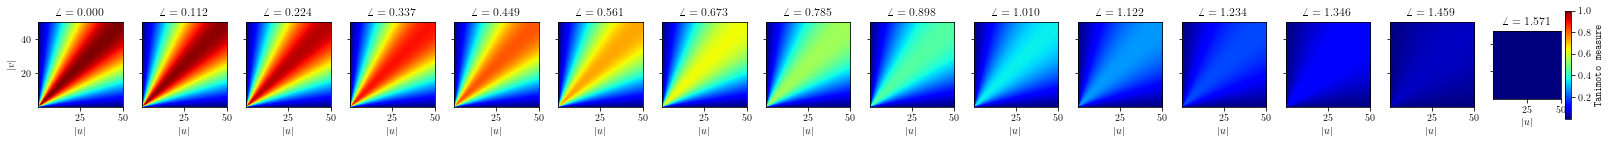

In [155]:
visualize_tanimoto(15)
plt.show()

In [151]:
def show_tanimoto_boundaries_real_vec_len():
    length = 1
    fun = lambda x: 0.5 * ((1 + 1 / x) + np.sqrt((1 + 1 / x) ** 2 - 4))
    x = np.linspace(0.1, 1.0, num=1000)
    fig = plt.figure(figsize=(8, 4))
    plt.plot(x, 1 / fun(x) * length, label=r"$$\frac{1}{\alpha}|u|$$")
    plt.plot(x, fun(x) * length, label=r"$$\alpha|u|$$")
    plt.xlabel(r"$\varepsilon$")
    plt.legend()
    plt.show()

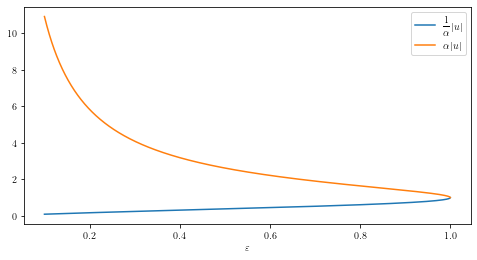

In [152]:
show_tanimoto_boundaries_real_vec_len()

In [153]:
def show_tanimoto_boundaries_zpn_vec_len():
    length = 2
    fun = lambda x: x
    x = np.linspace(0.1, 1.0, num=1000)
    fig = plt.figure(figsize=(8, 4))
    plt.plot(x, fun(x) * length, label=r"$\varepsilon |u|$")
    plt.plot(x, 1 / fun(x) * length, label=r"$\frac{1}{\varepsilon} |u|$")
    plt.xlabel(r"$\varepsilon$")
    plt.legend()
    plt.show()

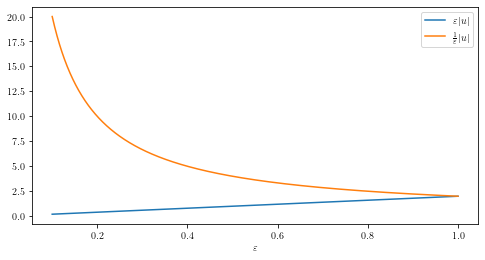

In [154]:
show_tanimoto_boundaries_zpn_vec_len()

## Conclusions

- Tanimoto provides quite interpretable understanding of DBSCAN's behaviour
- It also allows us to apply two heuristics that speed up results significantly
- There is no good measure for clustering quality